In [79]:
import sys
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import corner as corner


sys.path.append('../')
import utils as ut
import extrapolation as ext

In [46]:
n_epochs = 1000
check_every = 10
n_networks = 5

In [35]:
data = np.load(f'../extrapolation_data/1000/_{n_epochs}_{check_every}.npz')

In [36]:
list(data.keys())

['train', 'val', 'KL', 'post_samples']

Text(0.5, 1.0, '1000 epochs')

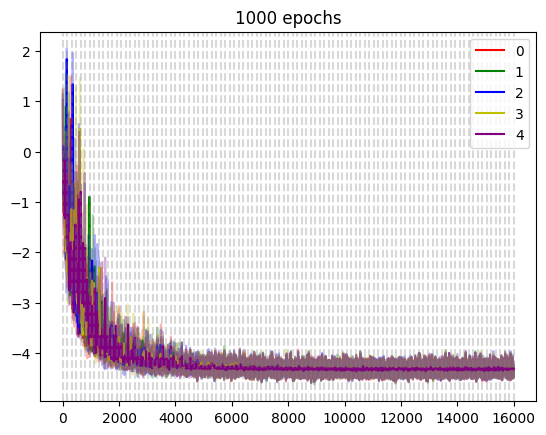

In [37]:
ut.plot_losses(data['train'], data['val'], check_every)  
plt.title(str(n_epochs)+' epochs') 

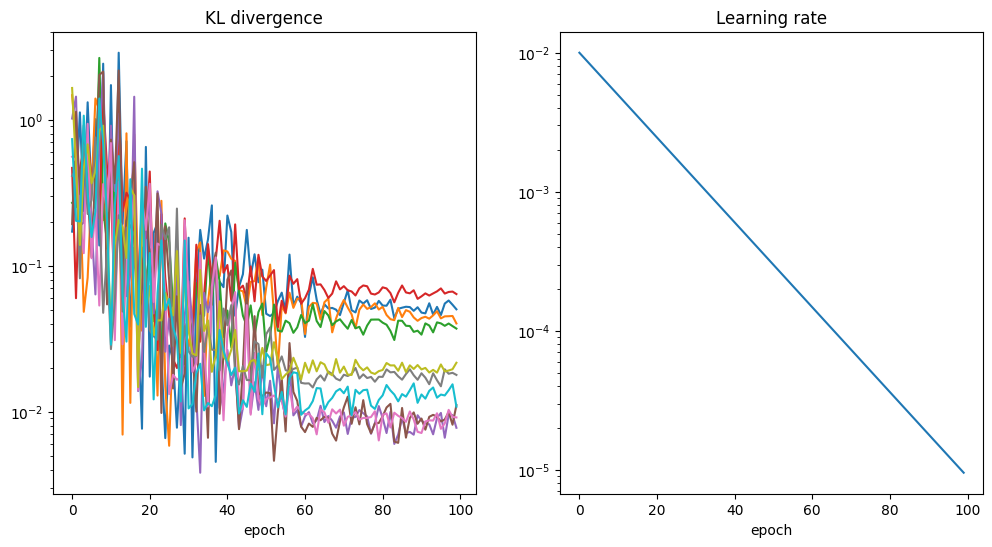

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(data['KL'].shape[1]):
    ax[0].plot(data['KL'][:,i], label=f"{i}")

ax[0].set_title('KL divergence')
ax[0].set_xlabel('epoch')
ax[0].set_yscale('log')

x = np.arange(data['KL'].shape[0])
ax[1].plot(1e-2 * .9**(x/1.5) )
ax[1].set_title('Learning rate')
ax[1].set_xlabel('epoch')
ax[1].set_yscale('log')


In [68]:
xx = .5 * torch.tensor((1 - np.abs( np.linspace(-1, 1, 10) ) **.25))

In [69]:
observation_theta = ext.uniform_prior.sample((1,))
observation_data = ext.simulator(observation_theta)
full_data = observation_data + xx
print('Observation theta:', observation_theta)

Observation theta: tensor([0.7895])


In [70]:
mean_base = float(observation_data.mean())
std = .01 / np.sqrt(10)
dd_base = np.random.normal(mean_base, std, 10000)
print('Mean base:', mean_base)
print('Std:', std)


mean_full = float(full_data.mean())
dd_full = np.random.normal(mean_full, std, 10000)
print('Mean full:', mean_full)
print('Std:', std)

Mean base: 0.7847351431846619
Std: 0.0031622776601683794
Mean full: 0.870772056304404
Std: 0.0031622776601683794


In [71]:
density_estimators = [
        ext.density_estimator_extrapolation(
            num_samples=ext.def_batch_size,
            prior=ext.uniform_prior,
            simulator=ext.simulator,
            which_dataloader=ext.which_dataloader,
        )
        for _ in range(ext.n_networks)
    ]

In [72]:
for i in range(n_networks):
    density_estimators[i].load_state_dict(torch.load(f'../extrapolation_data/1000/network_{i}_{n_epochs}_{check_every}.pth'))

/tmp/ipykernel_228927/644264175.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  density_estimators[i].load_state_dict(torch.load(f'../extrapolation_data/1000/network_{i}

In [73]:
posteriors = []
for i in range(ext.n_networks):
    posteriors.append(ext.DirectPosterior(density_estimators[i], ext.uniform_prior))

In [74]:
p_samples_base = np.zeros((ext.n_networks, ext.n_samples))
for i in range(ext.n_networks):
    p_samples_base[i] = posteriors[i].sample(
                (ext.n_samples,), x=observation_data, show_progress_bars=False
            ).numpy()


In [75]:
pp_samples_base = [p_samples_base[i][(p_samples_base[i] > mean_base -10 *std) & (p_samples_base[i] < mean_base +10 *std )] for i in range(n_networks)]

In [76]:
p_samples_full = np.zeros((ext.n_networks, ext.n_samples))
for i in range(ext.n_networks):
    p_samples_full[i] = posteriors[i].sample(
                (ext.n_samples,), x=full_data, show_progress_bars=False
            ).numpy()


In [77]:
pp_samples_full = [p_samples_full[i][(p_samples_full[i] > mean_full -10 *std) & (p_samples_full[i] < mean_full +10 *std )] for i in range(n_networks)]

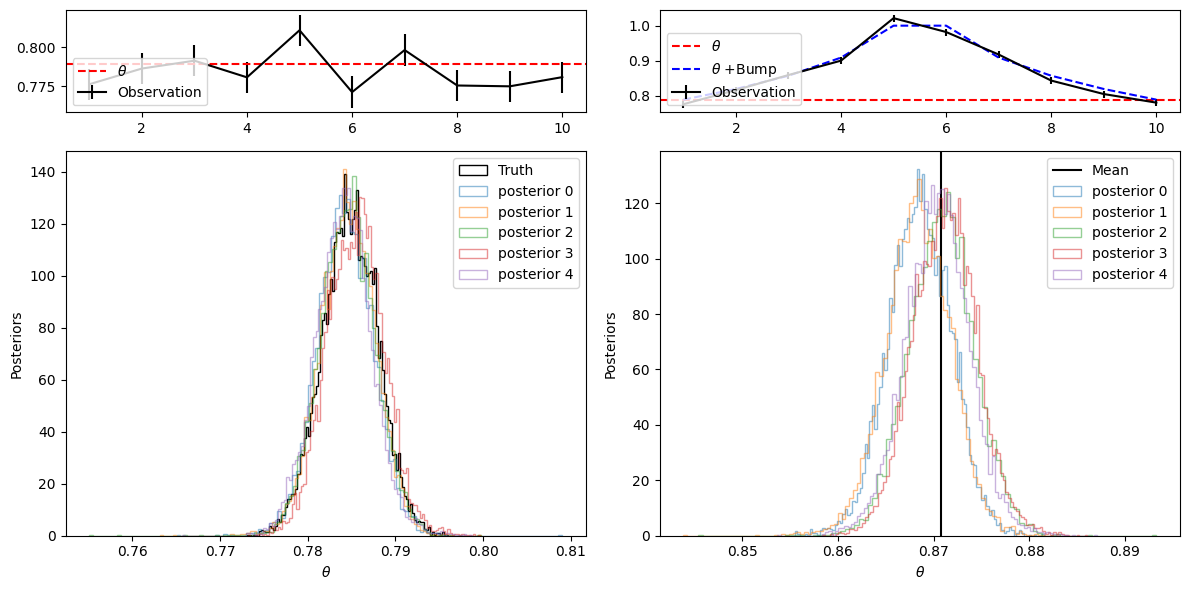

In [78]:
# Create figure
fig = plt.figure(figsize=(12, 6))

# Set up grid: 4 rows, 1 column (3 for main plot, 1 for small plot)
gs = gridspec.GridSpec(4, 2, figure=fig)

# Main plot takes up 3/4 of the figure
ax11 = fig.add_subplot(gs[0, 0])
ax11.errorbar(np.arange(1, 11, 1), observation_data, yerr=.01, label='Observation', color='black')
ax11.axhline(observation_theta, color='red', linestyle='--', label=r'$\theta$')
ax11.legend(loc=3)
#ax11.set_title('Observation')

# Smaller plot takes up 1/4 of the figure
ax12 = fig.add_subplot(gs[1:4, 0])
ax12.hist(dd_base, bins=100, density=True, label='Truth', histtype='step', color='black');
for i in range(n_networks):
    ax12.hist(pp_samples_base[i], bins=100, density=True, alpha=.5, label=f'posterior {i}', histtype='step');
ax12.set_xlabel(r'$\theta$')
ax12.set_ylabel('Posteriors')
ax12.legend()

# Main plot takes up 3/4 of the figure
ax21 = fig.add_subplot(gs[0, 1])
ax21.errorbar(np.arange(1, 11, 1), full_data, yerr=.01, label='Observation', color='black')
ax21.axhline(observation_theta, color='red', linestyle='--', label=r'$\theta$')
ax21.plot(np.arange(1, 11, 1), xx + observation_theta, color='blue', linestyle='--', label=r'$\theta$ +Bump')
ax21.legend(loc=3)
#ax21.set_title('Observation')

# Smaller plot takes up 1/4 of the figure
ax22 = fig.add_subplot(gs[1:4, 1])
ax22.axvline(mean_full, label='Mean', color='black');
for i in range(n_networks):
    ax22.hist(pp_samples_full[i], bins=100, density=True, alpha=.5, label=f'posterior {i}', histtype='step');
ax22.set_xlabel(r'$\theta$')
ax22.set_ylabel('Posteriors')
ax22.legend()

fig.tight_layout()

In [101]:
new_observation_theta = torch.tensor([-.5])
new_observation_data = ext.simulator(new_observation_theta)

full_data = new_observation_data + 15 * xx
mean_full = float(full_data.mean())
print('Mean full:', mean_full)

Mean full: 0.7869882959572788


In [102]:
alpha = np.geomspace(1e-2, 15, 100)
kl_vals = np.zeros((int(n_networks *(n_networks-1) / 2), len(alpha)))

for a in tqdm.tqdm(range(len(alpha))):
    full_data = new_observation_data + alpha[a] * xx
    
    k = 0
    for i in range(n_networks):
        for j in range(i+1, n_networks):
            kl_vals[k,a] = ext.my_KLval(posteriors[i], posteriors[j], 1e-3, 10000, observation=full_data)
            k += 1    

100%|██████████| 100/100 [07:08<00:00,  4.29s/it]


array([0.00356875, 0.01399878, 0.03099772])

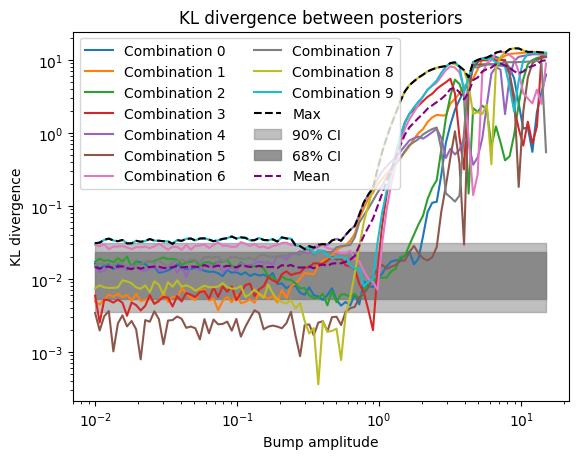

In [112]:
vals = np.quantile(kl_vals[:,:30], [.05, .16, .5, .84, .95], axis=0)
vv = np.mean(vals, axis=-1)

for i in range( int(n_networks *(n_networks-1) / 2) ):
    plt.loglog(alpha, kl_vals[i,:], label=f'Combination {i}')

plt.loglog(alpha, np.max(kl_vals, axis=0), label='Max', color='black', linestyle='--')
plt.fill_between(alpha, vv[0], vv[-1], alpha=.5, color='grey', label='90% CI')
plt.fill_between(alpha, vv[1], vv[-2], alpha=.85, color='grey', label='68% CI')
plt.loglog(alpha, np.mean(kl_vals, axis=0), label='Mean', color='purple', linestyle='--')
plt.xscale('log')
plt.xlabel('Bump amplitude')
plt.ylabel('KL divergence')
plt.title('KL divergence between posteriors')
plt.legend(ncol=2)
